# NBA Prediction Models - Midterm Report
## Kevin Yang, Eric Lee, Derek Young

Our main goal is to build prediction models for NBA team performance. As a first step, we will scrape data from `stats.nba.com` and store relevant data in a local `sqlite` database.

On a broad level, we have decided to focus our project on predicting the outcome of a given nba game. On a high level, our approach will involve determining the most important features in determining game outcomes, and then training a supervised machine learning model on these features over many previous games. There should be certain nuances that we should be careful to account for when modeling nba games. One of these is injuries. We need to find some way of determining the effect that an injured player will have on the result of a game.

In this deliverable, we will focus on data collection and understanding the data. We have provided snippets of code to demonstrate some of the work we have done. 

We will first write a simple scraping function to get player game logs.

In [39]:
import requests
import sqlite3
import pandas as pd
import numpy as np
import time
from datetime import datetime
from sklearn.svm import LinearSVC, SVC
from geopy.geocoders import Nominatim
from geopy.distance import vincenty

# Use svg backend for better quality
import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

In [40]:
def get_player_gamelogs(player_id, season):
    """ Given a player id (int or string) and a season (string, ex: 2016-17), returns a (header, log_list) where the
        header represents a key describing the format of a log in log list
    Input:
        player_id (int or string): player ID number
        season (str): season string, ex: 2016-17
    Output:
        (header, log_list): header is a key describing the format of a log in log list
    """
    
    player_url = ("http://stats.nba.com/stats/playergamelog?DateFrom=&DateTo=&LeagueID=00&PlayerID=" 
                  + str(player_id) + "&Season=" + season + "&SeasonType=Regular+Season")
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; rv:39.0) Gecko/20100101 Firefox/39.0'}
    
    # request the URL and parse the JSON
    response = requests.get(player_url, headers = headers)
    response.raise_for_status() # raise exception if invalid response
    response_json = response.json()
    log_list = response_json['resultSets'][0]['rowSet']
    header = response_json['resultSets'][0]['headers']
    
    return (header, log_list)

def convert_to_df(header, log_list):
    """ Given a header and a log_list, where header is a key describing the format of a log in log list and log_list
    contains a list of game logs, convert_to_dataframe returns this data in dataframe form
    Input:
        header (list): list of column labels
        log_list (list): 2D list containing game logs 
    Output:
        (pd.DataFrame): DataFrame containig the given data
    """
    index = np.arange(1, len(log_list) + 1)
    df = pd.DataFrame(index = index, columns = header)
    
    logs = np.array(log_list)
    logs_transpose = logs.T
    
    for i in xrange(len(header)):
        curr_header = header[i]
        df[curr_header] = logs_transpose[i]
    
    return df
    
#jeremy lin
player_id = 202391
season = "2016-17"

(header, plog_list) = get_player_gamelogs(player_id, season) 

player_df = convert_to_df(header, plog_list)

print player_df.head()

  SEASON_ID Player_ID     Game_ID     GAME_DATE      MATCHUP WL MIN FGM FGA  \
1     22016    202391  0021600057  NOV 02, 2016  BKN vs. DET  W  16   4   6   
2     22016    202391  0021600043  OCT 31, 2016  BKN vs. CHI  L  24   6  10   
3     22016    202391  0021600031  OCT 29, 2016    BKN @ MIL  L  33   4  16   
4     22016    202391  0021600019  OCT 28, 2016  BKN vs. IND  W  34   6  12   
5     22016    202391  0021600006  OCT 26, 2016    BKN @ BOS  L  28   6  14   

  FG_PCT       ...       DREB REB AST STL BLK TOV PF PTS PLUS_MINUS  \
1  0.667       ...          2   2   4   0   0   1  0  10          8   
2    0.6       ...          2   2   4   4   0   3  0  14        -15   
3   0.25       ...          2   3  11   3   1   4  0  12         12   
4    0.5       ...          9   9   9   0   1   2  1  21          0   
5  0.429       ...          2   3   3   0   1   2  1  18         -3   

  VIDEO_AVAILABLE  
1               1  
2               1  
3               1  
4               1 

Now that we have a function that extracts player game logs, we might be interested in understanding the importance of thhese player statistics as a predictor for team wins or losses. We can create some bar charts comparing player statistics in wins or losses. 

Additionally, instead of treating wins and losses as binary variables, we can also consider the relationship between player statistics and the point differential in any given game.

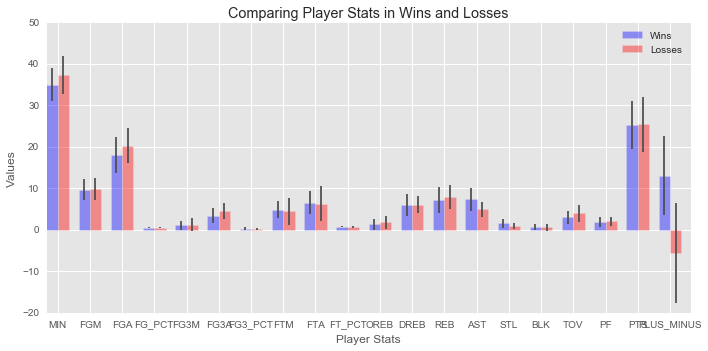

In [41]:
def display_player_wl(player_id, season):
    """ Given a player id (int or string) and a season (string, ex: 2016-17), displays graphs comparing the players
    performance in wins and losses
    Input:
        player_id (int or string): player ID number
        season (str): season string, ex: 2016-17
    Output:
        (header, log_list): header is a key describing the format of a log in log list
    """
    
    (headers, log_list) = get_player_gamelogs(player_id, season)
    
    df = convert_to_df(headers, log_list)
    
    # get rows corresponding to wins / losses
    df_w = df[df['WL'] == 'W']
    df_l = df[df['WL'] == 'L']
    
    # get numerical columns
    num_list = ['MIN','FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB',
                  'AST','STL','BLK','TOV','PF','PTS','PLUS_MINUS']
    
    # get numerical columns
    w_num = df_w.loc[:,['MIN','FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB',
                  'AST','STL','BLK','TOV','PF','PTS','PLUS_MINUS']]
    l_num = df_l.loc[:,['MIN','FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB',
                  'AST','STL','BLK','TOV','PF','PTS','PLUS_MINUS']]
    
    w_mean_list = []
    w_std_list = []
    l_mean_list = []
    l_std_list = []
    
    for i in num_list:
        w_float_list = w_num[i].values.astype(float)
        l_float_list = l_num[i].values.astype(float)
        w_mean_list.append(w_float_list.mean())
        l_mean_list.append(l_float_list.mean())
        w_std_list.append(w_float_list.std())
        l_std_list.append(l_float_list.std())
    
    n_groups = 20
    
    fig, ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = .35

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = plt.bar(index, w_mean_list, bar_width,
                     alpha=opacity,
                     color='b',
                     yerr=w_std_list,
                     error_kw=error_config,
                     label='Wins')

    rects2 = plt.bar(index + bar_width, l_mean_list, bar_width,
                     alpha=opacity,
                     color='r',
                     yerr=l_std_list,
                     error_kw=error_config,
                     label='Losses')


    plt.xlabel('Player Stats')
    plt.ylabel('Values')
    plt.title('Comparing Player Stats in Wins and Losses')
    #plt.xticks(index + bar_width, ('A', 'B', 'C', 'D', 'E'))
    plt.xticks(index + bar_width, num_list)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
# jeremy lin
# player_id = 202391
# season = "2016-17"

#lebron james
player_id = 2544
season = "2015-16"
display_player_wl(player_id, season)

The above graph is especially interesting because it demonstrates that the performance of a player (in this case, Lebron James) in a given game does not necessarily correlate with more wins. For example, on average Lebron gets more rebounds and (slightly) more points in losses. This is likely because in many wins the games might have been blowout games, so then Lebron would have played less. To account for this, we might wish to analyze the distribution of certain stats depending on the final point differential. To find this, we will work on creating a database of game IDs.

While creating this database of game IDs, we are also creating a database of team specific data. The team specific data is important because we suspect that many features that can be extracted from team data would be predictive for game resuls. These team-specific features, along with some player-specfic features, will be used in a supervised learning model to predict the result of an NBA game.

In [42]:
def get_league_gamelogs(season):
    """ Given a season (string, ex: 2016-17), returns a (header, log_list) where the
        header represents a key describing the format of a log in log list
    Input:
        season (str): season string, ex: 2016-17
    Output:
        (header, log_list): header is a key describing the format of a log in log list
    """
    league_log_url = ("http://stats.nba.com/stats/leaguegamelog?Counter=1000&DateFrom=&DateTo=&" + 
                  "Direction=DESC&LeagueID=00&PlayerOrTeam=T&Season=" + str(season) + 
                  "&SeasonType=Regular+Season&Sorter=PTS")
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; rv:39.0) Gecko/20100101 Firefox/39.0'}

    # request the URL and parse the JSON
    response = requests.get(league_log_url, headers = headers)
    response.raise_for_status() # raise exception if invalid response
    response_json = response.json()
    log_list = response_json['resultSets'][0]['rowSet']
    header = response_json['resultSets'][0]['headers']
    
    return (header, log_list)

def generate_year_list(start, yrs):
    """ Generate a year list to pass into load_all_gamlogs
    Input:
        start (int): The first year we are interested in loading
        yrs (int): How many years since start that we are including
    Output:
        (List): List of years
    """
    year_list = []
    curr_yr = start
    for i in xrange(yrs):
        nextyr = curr_yr + 1 
        year_list.append(str(curr_yr)+"-"+str(nextyr)[2:])
        curr_yr = nextyr
    return year_list
    
def load_all_gamelogs(conn, start, yrs):
    """ Load nba gamelog data for the past yrs years as a games tables into an SQLite database given in conn
    Input:
        conn (sqlite3.Connection): Connection object corresponding to the database; used to perform SQL commands.
        yrs (int): Number of years to include in table
    Output:
        None
    """
    
    cursor = conn.cursor()
    
    year_list = generate_year_list(start,yrs) #['2010-11', '2011-12', '2012-13', '2013-14', '2015-16', '2016-17']
    
    # clear league_log table
    cursor.execute('drop table if exists league_log')
    
    # create big table
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS league_log (
    season_id TEXT, 
    team_id INTEGER,
    team_abbreviation TEXT,
    team_name TEXT,
    game_id INTEGER,
    game_date INTEGER,
    matchup INTEGER,
    wl STRING,
    min INTEGER,
    fgm INTEGER,
    fga INTEGER,
    fg_pct REAL,
    fg3m INTEGER,
    fg3a INTEGER,
    fg3_pct REAL,
    ftm INTEGER,
    fta INTEGER,
    ft_pct REAL,
    oreb INTEGER,
    dreb INTEGER,
    reb INTEGER,
    ast INTEGER,
    stl INTEGER,
    blk INTEGER,
    tov INTEGER,
    pf INTEGER,
    pts INTEGER,
    plus_minus INTEGER
    )""")
    
    for year in year_list:
        (header, log_list) = get_league_gamelogs(year)
        
        question_marks = "(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ? ,?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"
        query_string = "INSERT INTO league_log VALUES " + question_marks
        for log in log_list:
            cursor.execute(query_string,
                          (log[0],log[1],log[2],log[3],log[4],log[5],log[6],log[7],
                          log[8], log[9], log[10], log[11], log[12], log[13], log[14],
                          log[15],log[16], log[17], log[18], log[19], log[20], log[21],
                          log[22], log[23], log[24], log[25], log[26], log[27]))
            
    conn.commit()

In [43]:
conn = sqlite3.connect(r"db/league.db")
conn.text_factory = str

start_year = 1946
length = 2017 - start_year

# TEST SET WILL BE SEASON 2015-16 + 2016-17??
# WHAT SHOULD TRAINING SET AND VALIDATION SET BE?

#print generate_year_list(start_year,length)
#load_all_gamelogs(conn, start_year, length )

In [44]:
league_df = pd.read_sql_query('SELECT * FROM league_log', conn)
print len(league_df)
league_df.head()

113790


,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,fgm,...,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus
0,21946,1610610025,CHS,Chicago Stags,24600208,1947-02-06,CHS vs. PIT,W,0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,109,24
1,21946,1610610025,CHS,Chicago Stags,24600284,1947-03-09,CHS @ CLR,W,0,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,107,30
2,21946,1610610025,CHS,Chicago Stags,24600280,1947-03-08,CHS vs. PRO,W,0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,107,26
3,21946,1610610036,WAS,Washington Capitols,24600199,1947-02-02,WAS @ CLR,W,0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,107,26
4,21946,1610610036,WAS,Washington Capitols,24600320,1947-03-26,WAS vs. CHS,W,0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,105,28


We have now loaded some league game logs into our database `league.db`. We can now write some data validation functions for our data, as we might be missing certain games.

In [45]:
def validate_data(df):
    year_list = df['season_id'].unique().tolist()
    
    for year in year_list:
        df_temp = df[df['season_id'] == year]
        
        if year == '22011':
            # lockout year
            assert(df_temp.shape[0] == 1980)
        elif year == '22016':
            # current ongoing year
            continue
        else:
            #normal 82 game sched
            assert(df_temp.shape[0] == 2460) 
        
#validate_data(league_df)

## Preprocessing and Understanding the Data
Now that we have stored key data points on each game, we wish to process the data to describe key features of our data, and then better understand these features through analyses and visualizations.

We first want to create a large league df with extra features, including the following:
1. Home W/L Percentage
2. Away W/L Percentage
3. Home Average Point Differential
4. Away Average Point Differential
5. Home W/L Percentage in Previous 8 Games
6. Away W/L Percentage in Previous 8 Games
7. Away W/L Percentage as Away Team
8. Home W/L Percentage as Home Team
9. Indicator whether the team is on a back-to-back

In [46]:
def preprocess(league_df):
    """ Given a dataframe league_df, returns new league_df by converting the 'game_date' column to datetime if 
    necessary, and adds is_home indicator and opp_team_id indicator
    Input:
        df (pandas.DataFrame): dataframe containing league logs
    Output:
        pandas.DataFrame
    """
    # convert to datetime, note this is in place!
    league_df['game_date'] = league_df['game_date'].apply(pd.to_datetime)
    
    # add new columns
    is_home = np.zeros(len(league_df), dtype=np.int64)
    opp_team_id = np.zeros(len(league_df), dtype=np.int64)
    wl_binary = np.zeros(len(league_df), dtype = np.int64)
    
    
    league_df = league_df.assign(is_home = is_home)
    league_df = league_df.assign(opp_team_id = opp_team_id)
    league_df = league_df.assign(wl_binary = wl_binary)
    
    
    # add home indicator variable
    for (index, row) in league_df.iterrows():
        matchup = row['matchup']
        if "@" in matchup:
            league_df.set_value(index, "is_home", 0)
        else:
            league_df.set_value(index, "is_home", 1)
            
    # add opposing team ID
    for (index,row) in league_df.iterrows():
        game_id = row['game_id']
        team_id = row['team_id']
        
        # find other game with the same game ID
        df_game = league_df[league_df['game_id'] == game_id]
        assert(len(df_game) == 2)
        found_opp = False
        for (inner_index,inner_row) in df_game.iterrows():
            curr_team_id = inner_row['team_id']
            if curr_team_id == team_id:
                continue
            else:
                # found opposing team, update opposing team ID
                league_df.set_value(index, 'opp_team_id', curr_team_id)
                found_opp = True
        assert(found_opp)
        
    # add binary representation of wins and losses
    for (index, row) in league_df.iterrows():
        wl = row['wl']
        if wl == 'W':
            league_df.set_value(index, 'wl_binary', 1)
        else:
            league_df.set_value(index, 'wl_binary', 0)
    
    return league_df
league_df = preprocess(league_df)
league_df.head(10)

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,fgm,...,ast,stl,blk,tov,pf,pts,plus_minus,is_home,opp_team_id,wl_binary
0,21946,1610610025,CHS,Chicago Stags,24600208,1947-02-06,CHS vs. PIT,W,0,48.0,...,NaN,NaN,NaN,NaN,28.0,109,24,1,1610610031,1
1,21946,1610610025,CHS,Chicago Stags,24600284,1947-03-09,CHS @ CLR,W,0,36.0,...,NaN,NaN,NaN,NaN,27.0,107,30,0,1610610026,1
2,21946,1610610025,CHS,Chicago Stags,24600280,1947-03-08,CHS vs. PRO,W,0,43.0,...,NaN,NaN,NaN,NaN,33.0,107,26,1,1610610032,1
3,21946,1610610036,WAS,Washington Capitols,24600199,1947-02-02,WAS @ CLR,W,0,43.0,...,NaN,NaN,NaN,NaN,15.0,107,26,0,1610610026,1
4,21946,1610610036,WAS,Washington Capitols,24600320,1947-03-26,WAS vs. CHS,W,0,42.0,...,NaN,NaN,NaN,NaN,16.0,105,28,1,1610610025,1
5,21946,1610612744,PHW,Philadelphia Warriors,24600157,1947-01-14,PHW @ HUS,W,0,44.0,...,NaN,NaN,NaN,NaN,NaN,104,30,0,1610610035,1
6,21946,1610612744,PHW,Philadelphia Warriors,24600310,1947-03-22,PHW @ PRO,W,0,35.0,...,NaN,NaN,NaN,NaN,NaN,103,21,0,1610610032,1
7,21946,1610610034,BOM,St. Louis Bombers,24600129,1947-01-01,BOM @ CHS,W,0,39.0,...,NaN,NaN,NaN,NaN,29.0,103,13,0,1610610025,1
8,21946,1610610025,CHS,Chicago Stags,24600221,1947-02-12,CHS @ PIT,W,0,40.0,...,NaN,NaN,NaN,NaN,NaN,101,19,0,1610610031,1
9,21946,1610610025,CHS,Chicago Stags,24600309,1947-03-21,CHS @ HUS,W,0,43.0,...,NaN,NaN,NaN,NaN,24.0,99,16,0,1610610035,1


In [47]:
new_df1 = league_df.sort_values('game_date')
new_df1[new_df1["team_abbreviation"] == "DAL"].head()

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,fgm,...,ast,stl,blk,tov,pf,pts,plus_minus,is_home,opp_team_id,wl_binary
34421,21980,1610612742,DAL,Dallas Mavericks,28000010,1980-10-11,DAL vs. SAN,W,240,41.0,...,NaN,NaN,NaN,NaN,32.0,103,11,1,1610612759,1
35035,21980,1610612742,DAL,Dallas Mavericks,28000024,1980-10-14,DAL vs. SEA,L,240,32.0,...,NaN,NaN,NaN,NaN,17.0,83,-2,1,1610612760,0
34712,21980,1610612742,DAL,Dallas Mavericks,28000029,1980-10-15,DAL @ DEN,L,240,36.0,...,NaN,NaN,NaN,NaN,35.0,98,-35,0,1610612743,0
34935,21980,1610612742,DAL,Dallas Mavericks,28000041,1980-10-17,DAL vs. KCK,L,240,37.0,...,NaN,NaN,NaN,NaN,20.0,91,-12,1,1610612758,0
34791,21980,1610612742,DAL,Dallas Mavericks,28000047,1980-10-18,DAL @ SAN,L,240,41.0,...,NaN,NaN,NaN,NaN,20.0,96,-14,0,1610612759,0


In [48]:
# LOCATION RELATED STUFF

# set base year
temp_df_1 = league_df[league_df['season_id'] >= '22005']
team_names = temp_df_1['team_name'].unique().tolist()
#print len(team_names), team_names

team_id_list = temp_df_1['team_id'].unique().tolist()
#print len(team_id_list), team_id_list

temp_df = temp_df_1[temp_df_1['team_name'] == 'New Orleans/Oklahoma City Hornets']
no_okc_seasons = temp_df['season_id'].unique().tolist()
#print "NO_OKC", no_okc_seasons

temp_df = temp_df_1[temp_df_1['team_name'] == 'Charlotte Bobcats']
bobcats = temp_df['season_id'].unique().tolist()
#print "BOB", bobcats

temp_df = temp_df_1[temp_df_1['team_name'] == 'New Jersey Nets']
nj = temp_df['season_id'].unique().tolist()
#print "NJ", nj

temp_df = temp_df_1[temp_df_1['team_name'] == 'Seattle SuperSonics']
seattle = temp_df['season_id'].unique().tolist()
#print "SUPER", seattle

temp_df = temp_df_1[temp_df_1['team_name'] == 'New Orleans Hornets']
noh = temp_df['season_id'].unique().tolist()
#print "NOH", noh

temp_df = temp_df_1[temp_df_1['team_name'] == 'Oklahoma City Thunder']
thunder = temp_df['season_id'].unique().tolist()
#print "THUNDER", thunder

temp_df = temp_df_1[temp_df_1['team_name'] == 'Brooklyn Nets']
bkn = temp_df['season_id'].unique().tolist()
#print "BKN", bkn

# dictionary mapping of team_id to team_names?
id_team = dict()
for team_id in team_id_list:
    temp_df = temp_df_1[temp_df_1['team_id'] == team_id]
    id_team[team_id] = temp_df['team_name'].unique().tolist()
#print id_team

# dictionary mapping of team_name to seasons
team_seasons = dict()
for team_name in team_names:
    temp_df = temp_df_1[temp_df_1['team_name'] == team_name]
    team_seasons[team_name] = temp_df['season_id'].unique().tolist()
#print team_seasons

# sanity check
for team_id in team_id_list:
    names = id_team[team_id]
    if len(names) == 0:
        raise Fail("no names for ID")
    elif len(names) == 1:
        continue
    else:
        season_list = []
        for name in names:
            seasons = team_seasons[name]
            season_list.append(seasons)
            
        common_years = list(reduce(set.intersection, map(set, season_list)))
        #print len(common_years), names, common_years
        assert(len(common_years) == 0)
            
# ['Dallas Mavericks', 'New Orleans/Oklahoma City Hornets', 'Milwaukee Bucks', 'San Antonio Spurs', 
#  'Philadelphia 76ers', 'Phoenix Suns', 'Denver Nuggets', 'Sacramento Kings', 'Atlanta Hawks', 'Miami Heat', 
#  'Toronto Raptors', 'New Jersey Nets', 'Houston Rockets', 'Boston Celtics', 'Golden State Warriors', 
#  'Utah Jazz', 'Seattle SuperSonics', 'Portland Trail Blazers', 'Indiana Pacers', 'Minnesota Timberwolves', 
#  'Washington Wizards', 'Chicago Bulls', 'New York Knicks', 'Cleveland Cavaliers', 'Charlotte Bobcats', 
#  'Detroit Pistons', 'Memphis Grizzlies', 'Orlando Magic', 'Los Angeles Clippers', 'Los Angeles Lakers', 
#  'New Orleans Hornets', 'Oklahoma City Thunder', 'Brooklyn Nets', 'New Orleans Pelicans', 'Charlotte Hornets', 
#  'LA Clippers']

name_location = {'Dallas Mavericks': 'Dallas, Texas',
                'New Orleans/Oklahoma City Hornets': 'Oklahoma City, Oklahoma',
                'Milwaukee Bucks': 'Milwaukee, Wisconsin',
                'San Antonio Spurs': 'San Antonio, Texas',
                'Philadelphia 76ers': 'Philadelphia, Pennsylvania',
                'Phoenix Suns': 'Phoenix, Arizona',
                'Denver Nuggets': 'Denver, Colorado',
                'Sacramento Kings': 'Sacramento, California',
                'Atlanta Hawks': 'Atlanta, Georgia',
                'Miami Heat' : 'Miami, Florida', 
                'Toronto Raptors': 'Toronto, Ontario', 
                'New Jersey Nets': 'Newark, New Jersey', 
                'Houston Rockets': 'Houston, Texas', 
                'Boston Celtics': 'Boston, Massachusetts', 
                'Golden State Warriors' : 'Oakland, California', 
                'Utah Jazz': 'Salt Lake City, Utah', 
                'Seattle SuperSonics' : 'Seattle, Washington', 
                'Portland Trail Blazers': 'Portland, Oregon', 
                'Indiana Pacers' : 'Indianapolis, Indiana', 
                'Minnesota Timberwolves' : 'Minneapolis, Minnesota', 
                'Washington Wizards': 'Washington D.C., Virginia',
                'Chicago Bulls' : 'Chicago, Illinois', 
                'New York Knicks': 'New York City, New York', 
                'Cleveland Cavaliers' : 'Cleveland, Ohio', 
                'Charlotte Bobcats' : 'Charlotte, North Carolina',
                'Detroit Pistons' : 'Detroit, Michigan', 
                'Memphis Grizzlies' : 'Memphis, Tennessee', 
                'Orlando Magic' : 'Orlando, Florida', 
                'Los Angeles Clippers' : 'Los Angeles, California', 
                'Los Angeles Lakers' : 'Los Angeles, California', 
                'New Orleans Hornets' : 'New Orleans, Louisiana', 
                'Oklahoma City Thunder': 'Oklahoma City, Oklahoma', 
                'Brooklyn Nets': 'Brooklyn, New York', 
                'New Orleans Pelicans' : 'New Orleans, Louisiana', 
                'Charlotte Hornets' : 'Charlotte, North Carolina', 
                'LA Clippers' : 'Los Angeles, California'}

location_latlong = dict()

geolocator = Nominatim()

for key,value in name_location.iteritems():
    geo_loc = geolocator.geocode(value)
    (lat1, long1) = (geo_loc.latitude, geo_loc.longitude)
    location_latlong[value] = (lat1,long1)

print location_latlong

def get_team_location(team_id, season_id):
    """ Given a team id and the season_id, returns a string containing the location of the team stadium
    Input: 
        team_id (int): team id
        season_id (str): season id 
    Output:
        (str) 
    """
    names = id_team[team_id]
    
    team_name = None
    
    for name in names:
        seasons = team_seasons[name]
        #print seasons, name
        if season_id in seasons:
            team_name = name
            
    if team_name == None:
        print (team_id, season_id, names)
        assert(False)
    
    return name_location[team_name]

location = get_team_location(1610612742, '22015')
location1 = get_team_location(1610612749, '22015')

#print location, location1

# geolocator = Nominatim()
# geo_loc = geolocator.geocode(location)

# (lat1, long1) = (geo_loc.latitude, geo_loc.longitude)

# geo_loc1 = geolocator.geocode(location1)

# (lat2, long2) = (geo_loc1.latitude, geo_loc1.longitude)

#print vincenty((lat1,long1), (lat2,long2)).miles
    
#print Geocoder.geocode(location).valid_address

{'Detroit, Michigan': (42.3486635, -83.0567374), 'Houston, Texas': (29.7589382, -95.3676973), 'Charlotte, North Carolina': (35.2270869, -80.8431267), 'Minneapolis, Minnesota': (44.9772995, -93.2654691), 'Orlando, Florida': (28.5421175, -81.3790461), 'Philadelphia, Pennsylvania': (39.9523993, -75.1635898), 'Cleveland, Ohio': (41.5051613, -81.6934445), 'Dallas, Texas': (32.7762719, -96.7968558), 'Memphis, Tennessee': (35.1490215, -90.0516284), 'Salt Lake City, Utah': (40.7670126, -111.8904307), 'Newark, New Jersey': (40.735657, -74.1723666), 'Portland, Oregon': (45.5202471, -122.6741948), 'Boston, Massachusetts': (42.3604823, -71.0595677), 'Toronto, Ontario': (43.6529206, -79.3849007), 'Seattle, Washington': (47.6038321, -122.3300623), 'Denver, Colorado': (39.7391536, -104.9847033), 'Sacramento, California': (38.5815719, -121.4943995), 'Washington D.C., Virginia': (38.8927292, -77.0419093), 'Chicago, Illinois': (41.8755546, -87.6244211), 'Oakland, California': (37.8044557, -122.2713562),

In [49]:
def add_extra_features(league_df, new_years = False):
    """ Given a dataframe league_df, returns a new df containing extra columns for each new feature.
        If new_years = true, adds features that only work for data frames containing data >= 2005
    Input:
        league_df (pandas.DataFrame): dataframe containing league logs
        new_years (bool): if the dataframe contains only data >= 2005
    Output:
        pd.DataFrame
    """
    
    geolocator = Nominatim()
    
    seen_distances = dict()
    
    lookback = 8

    #print league_df['game_date'].dtype
    
    #converted_row = pd.to_datetime(league_df['game_date'])
    #print league_df['game_date'].dtype
    
    new_df = league_df.sort_values('game_date')
    
    # add new columns
    home_win_pct = np.zeros(len(new_df))
    away_win_pct = np.zeros(len(new_df))
    home_avg_pt_diff = np.zeros(len(new_df))
    away_avg_pt_diff = np.zeros(len(new_df))
    home_win_pct_N = np.zeros(len(new_df))
    away_win_pct_N = np.zeros(len(new_df))
    away_win_pct_as_away = np.zeros(len(new_df))
    home_win_pct_as_home = np.zeros(len(new_df))
    home_back_to_back = np.zeros(len(new_df))
    away_back_to_back = np.zeros(len(new_df))
    home_game_count = np.zeros(len(new_df))
    away_game_count = np.zeros(len(new_df))
    home_mileage = np.zeros(len(new_df))
    away_mileage = np.zeros(len(new_df))
    
    new_df = new_df.assign(home_win_pct = home_win_pct)
    new_df = new_df.assign(away_win_pct = away_win_pct)
    new_df = new_df.assign(home_avg_pt_diff = home_avg_pt_diff)
    new_df = new_df.assign(away_avg_pt_diff = away_avg_pt_diff)
    new_df = new_df.assign(home_win_pct_N = home_win_pct_N)
    new_df = new_df.assign(away_win_pct_N = away_win_pct_N)
    new_df = new_df.assign(away_win_pct_as_away = away_win_pct_as_away)
    new_df = new_df.assign(home_win_pct_as_home = home_win_pct_as_home)
    new_df = new_df.assign(home_back_to_back = home_back_to_back)
    new_df = new_df.assign(away_back_to_back = away_back_to_back)
    new_df = new_df.assign(home_game_count = home_game_count)
    new_df = new_df.assign(away_game_count = away_game_count)
    
    if (new_years):
        new_df = new_df.assign(home_mileage = home_mileage)
        new_df = new_df.assign(away_mileage = away_mileage)
    
    # add features
    grouped = new_df.groupby(['season_id'])
    groupList = [grouped.get_group(x) for x in grouped.groups]
    
    for season_df in groupList:
        # initialize dictionary containing wins and losses for each team
        win_dict = dict()
        lose_dict = dict()
        running_dict = dict()
        
        # stores list of game dates for each team
        running_date_dict = dict()
        
        # total plus minus so far
        plus_minus_dict = dict()
        
        # stores home and away game counts and w/l counts
        wins_as_home = dict()
        wins_as_away = dict()
        games_as_home = dict()
        games_as_away = dict()
        
        running_locations = dict()
        
        for team in season_df['team_id'].unique():
            win_dict[team] = 0
            lose_dict[team] = 0
            running_dict[team] = []
            plus_minus_dict[team] = 0
            running_date_dict[team] = []
            
            # track wins at home, at away, and total games at home, at away
            wins_as_home[team] = 0
            wins_as_away[team] = 0
            games_as_home[team] = 0
            games_as_away[team] = 0
            
            # track list of locations played at
            running_locations[team] = []
        
        # sort season by day
        season_df = season_df.sort_values('game_date')
        
        seen_games = set()
        
        for (index, row) in season_df.iterrows():
            is_home = row['is_home']
            team_id = row['team_id']
            opp_team_id = row['opp_team_id']
            wl = row['wl']
            game_id = row['game_id']
            curr_team_plus_minus = row['plus_minus']
            opp_team_plus_minus = -curr_team_plus_minus
            game_date = row['game_date']
            
            season_id = row['season_id']
            
            if is_home == 1:
                home_team_id = team_id
                away_team_id = opp_team_id
            else:
                home_team_id = opp_team_id
                away_team_id = team_id

            home_win_pct = 0
            away_win_pct = 0

            if win_dict[home_team_id] + lose_dict[home_team_id] > 0:
                home_win_pct = (win_dict[home_team_id])/float(win_dict[home_team_id] + lose_dict[home_team_id])
            if win_dict[away_team_id] + lose_dict[away_team_id] > 0:
                away_win_pct = (win_dict[away_team_id])/float(win_dict[away_team_id] + lose_dict[away_team_id])
                
            new_df.set_value(index, 'home_win_pct', home_win_pct)
            new_df.set_value(index, 'away_win_pct', away_win_pct)

            home_win_pct_N = 0
            away_win_pct_N = 0
            
            home_games_count = len(running_dict[home_team_id])
            away_games_count = len(running_dict[away_team_id])
            
            new_df.set_value(index, 'home_game_count', home_games_count)
            new_df.set_value(index, 'away_game_count', away_games_count)
            
            if home_games_count > 0:
                if home_games_count > lookback:
                    lookback_games = running_dict[home_team_id][home_games_count - lookback:]
                else:
                    lookback_games = running_dict[home_team_id]
                home_win_pct_N = sum(lookback_games)/float(len(lookback_games))
                
            if away_games_count > 0:
                if away_games_count > lookback:
                    lookback_games = running_dict[away_team_id][away_games_count - lookback:]
                else:
                    lookback_games = running_dict[away_team_id]
                away_win_pct_N = sum(lookback_games)/float(len(lookback_games))
                
            new_df.set_value(index, 'home_win_pct_N', home_win_pct_N)
            new_df.set_value(index, 'away_win_pct_N', away_win_pct_N)
                
            home_avg_pt_diff = 0
            away_avg_pt_diff = 0
            
            if home_games_count > 0:
                running_pt_diff = plus_minus_dict[home_team_id]
                home_avg_pt_diff = running_pt_diff/float(home_games_count)
            if away_games_count > 0:
                running_pt_diff = plus_minus_dict[away_team_id]
                away_avg_pt_diff = running_pt_diff/float(away_games_count)
                
            new_df.set_value(index, 'home_avg_pt_diff', home_avg_pt_diff)
            new_df.set_value(index, 'away_avg_pt_diff', away_avg_pt_diff)
                
            home_back_to_back = 0
            away_back_to_back = 0
            
            if home_games_count > 0:
                most_recent_date = running_date_dict[home_team_id][home_games_count - 1]
                #most_recent_date = datetime.strptime(most_recent_date, "%Y-%m-%d")
                #curr_date = datetime.strptime(game_date, "%Y-%m-%d")
                
                if game_date.toordinal() - most_recent_date.toordinal() == 1:
                    # back to back
                    home_back_to_back = 1
                
            if away_games_count > 0:
                most_recent_date = running_date_dict[away_team_id][away_games_count - 1]
                #most_recent_date = datetime.strptime(most_recent_date, "%Y-%m-%d")
                #curr_date = datetime.strptime(game_date, "%Y-%m-%d")
                
                if game_date.toordinal() - most_recent_date.toordinal() == 1:
                    # back to back
                    away_back_to_back = 1
                    
            new_df.set_value(index, 'home_back_to_back', home_back_to_back)
            new_df.set_value(index, 'away_back_to_back', away_back_to_back)
            
            #update home_win_pct_as_home, away_win_pct_as_away
            home_win_pct_as_home = 0
            away_win_pct_as_away = 0
            
            home_games_as_home = games_as_home[home_team_id]
            away_games_as_away = games_as_away[away_team_id]
            
            if (home_games_as_home > 0):
                home_win_pct_as_home = (wins_as_home[home_team_id])/float(home_games_as_home)
            if (away_games_as_away > 0):
                away_win_pct_as_away = (wins_as_away[away_team_id])/float(away_games_as_away)
                
            new_df.set_value(index, 'home_win_pct_as_home', home_win_pct_as_home)
            new_df.set_value(index, 'away_win_pct_as_away', away_win_pct_as_away)
            
            home_mileage = 0
            away_mileage = 0
            
            curr_location = None
            
            if (new_years):
                curr_location = get_team_location(home_team_id, season_id)
            
                #curr_geo = geolocator.geocode(curr_location)
                #if (curr_geo == None):
                #    print "curr", curr_location
                
                #(curr_lat, curr_long) = (curr_geo.latitude, curr_geo.longitude)
                
                (curr_lat, curr_long) = location_latlong[curr_location]

                if home_games_count > 0:
                    location_list = running_locations[home_team_id]
                    assert(len(location_list) == home_games_count)
                    last_location = location_list[len(location_list) - 1]
                    #last_geo = geolocator.geocode(last_location)
                    #if last_geo == None:
                    #    print "last home", last_location
                    #(last_lat, last_long) = (last_geo.latitude, last_geo.longitude)
                    (last_lat, last_long) = location_latlong[last_location]
                    
                    str1 = curr_location + last_location
                    str2 = last_location + curr_location
                    
                    if str1 in seen_distances:
                        home_mileage = seen_distances[str1]
                    elif str2 in seen_distances:
                        home_mileage = seen_distances[str2]
                    else:
                        home_mileage = vincenty((last_lat,last_long), (curr_lat,curr_long)).miles
                        seen_distances[str1] = home_mileage

                if away_games_count > 0:
                    location_list = running_locations[away_team_id]
                    assert(len(location_list) == away_games_count)
                    last_location = location_list[len(location_list) - 1]
                    
                    (last_lat, last_long) = location_latlong[last_location]
                    
                    str1 = curr_location + last_location
                    str2 = last_location + curr_location
                    
                    if str1 in seen_distances:
                        away_mileage = seen_distances[str1]
                    elif str2 in seen_distances:
                        away_mileage = seen_distances[str2]
                    else:
                        away_mileage = vincenty((last_lat,last_long), (curr_lat,curr_long)).miles
                        seen_distances[str1] = away_mileage
                    
                    #last_location = running_locations[away_team_id][len(running_locations) - 1]
#                     last_geo = geolocator.geocode(last_location)
#                     if last_geo == None:
#                         print "last away", last_location
#                     (last_lat, last_long) = (last_geo.latitude, last_geo.longitude)

#                     away_mileage = vincenty((last_lat,last_long), (curr_lat,curr_long)).miles

                new_df.set_value(index, 'home_mileage', home_mileage)
                new_df.set_value(index, 'away_mileage', away_mileage)  
                
            # update running stats
            if (wl == 'W'):
                if game_id in seen_games:
                    win_dict[team_id] += 1
                    lose_dict[opp_team_id] += 1
                    running_dict[team_id].append(1)
                    running_dict[opp_team_id].append(0)
                    
                    # update home team and away team w/l
                    if is_home == 1:
                        wins_as_home[team_id] += 1
                        games_as_home[team_id] += 1
                        games_as_away[opp_team_id] += 1
                    else:
                        wins_as_away[team_id] += 1
                        games_as_away[team_id] += 1
                        games_as_home[opp_team_id] += 1
                    
            else:
                if game_id in seen_games:
                    win_dict[opp_team_id] += 1
                    lose_dict[team_id] += 1
                    running_dict[opp_team_id].append(1)
                    running_dict[team_id].append(0)
                    
                    # update home team and away team w/l
                    if is_home == 1:
                        wins_as_away[opp_team_id] += 1
                        games_as_away[opp_team_id] += 1
                        games_as_home[team_id] += 1
                        
                    else:
                        wins_as_home[opp_team_id] += 1
                        games_as_home[opp_team_id] += 1
                        games_as_away[team_id] += 1
            if game_id in seen_games:
                plus_minus_dict[team_id] += curr_team_plus_minus
                plus_minus_dict[opp_team_id] += opp_team_plus_minus
                running_date_dict[team_id].append(game_date)
                running_date_dict[opp_team_id].append(game_date)
                
                #location = get_team_location[home_team_id]
                
                if (new_years):
                    running_locations[home_team_id].append(curr_location)
                    running_locations[away_team_id].append(curr_location)
                
            seen_games.add(game_id)
    return new_df

In [50]:
cutoff = 10
new_df = add_extra_features(league_df)

# all games contains away games and home games, without any cutoff


all_games = new_df
home_games = new_df[new_df['is_home'] == 1]
home_games_with_cutoff = home_games[home_games['home_game_count'] >= cutoff]


print home_games_with_cutoff.head(20)
print home_games_with_cutoff["home_win_pct_as_home"]
pd.DataFrame.to_csv(home_games_with_cutoff, 'home_games_with_cutoff.csv')
print len(home_games_with_cutoff[home_games_with_cutoff['season_id'] == '22015'])

new_years_df = league_df[league_df['season_id'] >= "22005"]
new_years_df = add_extra_features(new_years_df, True)

new_years_df['pts']


    season_id     team_id team_abbreviation                team_name  \
569     21946  1610610025               CHS            Chicago Stags   
316     21946  1610610035               HUS          Toronto Huskies   
363     21946  1610610028               DEF          Detroit Falcons   
453     21946  1610610031               PIT       Pittsburgh Ironmen   
177     21946  1610610036               WAS      Washington Capitols   
528     21946  1610610032               PRO  Providence Steamrollers   
511     21946  1610612738               BOS           Boston Celtics   
235     21946  1610610025               CHS            Chicago Stags   
234     21946  1610610035               HUS          Toronto Huskies   
119     21946  1610610032               PRO  Providence Steamrollers   
490     21946  1610610034               BOM        St. Louis Bombers   
412     21946  1610612752               NYK          New York Knicks   
623     21946  1610610036               WAS      Washington Capi

88251      91
86993     108
88093      93
86647     117
86992     108
87398     102
88973      67
86848     111
86725     114
88323      90
88091      93
87543     100
86991     108
88092      93
88859      78
88746      82
87772      97
88405      89
88860      78
87774      97
86941     109
86572     122
88324      90
86940     109
88505      87
88454      88
87169     105
87614      99
87613      99
87692      98
         ... 
113709     88
113674     91
113662     92
113311    110
113739     85
113610     95
113537     99
113538     99
113385    106
113136    124
113708     88
113732     86
113504    101
113291    111
113310    110
113786     62
113787     54
113788     53
113480    102
113748     84
113629     94
113691     90
113240    114
113239    114
113197    117
113536     99
113462    103
113707     88
113327    109
113789     52
Name: pts, dtype: int64

In [51]:
cutoff_test = home_games_with_cutoff[(home_games_with_cutoff['season_id'] == '22015') &
                                    (home_games_with_cutoff['home_game_count'] >= 10)]
print len(cutoff_test)

#pd.DataFrame.to_csv(home_games_with_cutoff, 'home_games_with_cutoff.csv')

1078


In [52]:
#print home_games_with_cutoff["team_abbreviation"].head(n=100)
#print home_games_with_cutoff["home_win_pct"].head(n=100)
#print home_games_with_cutoff["away_win_pct"].head(n=100)

newdf = home_games_with_cutoff[(home_games_with_cutoff["team_abbreviation"] =="DAL")]
#print newdf["home_win_pct"].head()
#print newdf["away_win_pct"].head()
#print newdf.head(n=20)


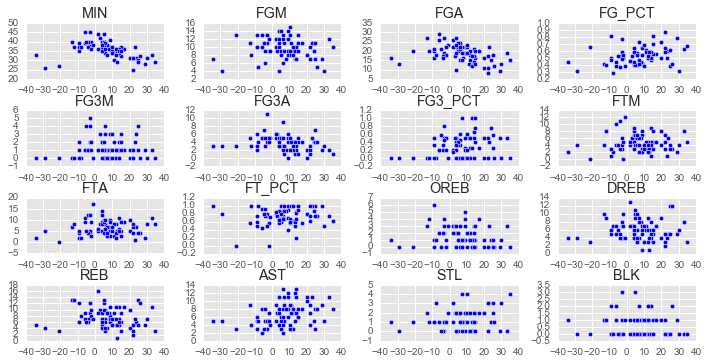

In [53]:
def add_point_diff(league_df, player_id, season):
    """ Given a dataframe df, player id (int or string) and a season (string, ex: 2016-17), 
        returns a player log list df containing a new column pt_diff
    Input:
        df (pandas.DataFrame): dataframe containing league logs
        player_id (int or string): player ID number
        season (str): season string, ex: 2016-17
    Output:
        pd.DataFrame
    """
    
    (headers, log_list) = get_player_gamelogs(player_id, season)
    
    df = convert_to_df(headers, log_list)
    
    # point_differentials
    pt_diff = []
    
    for (index, row) in df.iterrows():
        wl = row['WL']
        game_id = int(row['Game_ID'])
        
        # there should be exactly one game with these properties
        single_game_df = league_df[(league_df['game_id'] == game_id) & (league_df['wl'] == wl)]
    
        assert(len(single_game_df) == 1)
        curr_pt_diff = single_game_df['plus_minus'].values[0]
        pt_diff.append(curr_pt_diff)
        
    new_df = df.assign(pt_diff = np.array(pt_diff))
    
    return new_df
        
def graph_point_diff(league_df, player_id, season):
    """ Given a dataframe df, player id (int or string) and a season (string, ex: 2016-17), 
        displays scatter plots comparing the players performance to resulting point differential
    Input:
        league_df (pandas.DataFrame): dataframe containing league logs
        player_id (int or string): player ID number
        season (str): season string, ex: 2016-17
    Output:
        None
    """
    
    new_df = add_point_diff(league_df, player_id, season)
    
    rows, cols = 4, 4
    
    f, axarr = plt.subplots(rows, cols)
    plt.tight_layout()
    
    # get numerical columns
    num_list = ['MIN','FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB',
                  'AST','STL','BLK','TOV','PF','PTS','PLUS_MINUS']
    
    for i in xrange(rows):
        for j in xrange(cols):
            index = i*rows + j
            
            if index > 19:
                continue
            
            curr_col = num_list[index]
            y_array = np.array(new_df[curr_col].astype(float).values)
            x_array = np.array(new_df['pt_diff'].astype(float).values)
                
            axarr[i,j].scatter(x_array, y_array)
            axarr[i,j].title.set_text(curr_col)
                
# example jeremy lin
# player_id = 202391
# season = "2016-17"
# team_id = 1610612751
    
#lebron james
player_id = 2544
season = "2015-16"

#new_df = 
graph_point_diff(league_df, player_id, season)

#new_df.head()



In [54]:
#temp_df = home_games_with_cutoff[home_games_with_cutoff['season_id']>="22005"]
temp_df = new_years_df[new_years_df['is_home'] == 1]

temp_df.head()
altitude = {'Chicago Stags': 615, 'Buffalo Braves': 600, 'Washington Bullets': 400, 'Toronto Huskies': 249, 
            'Los Angeles Lakers': 233, 'Chicago Bulls': 615, 'Washington Capitols': 200, 'Providence Steamrollers': 75, 
            'Charlotte Bobcats': 751, 'Capital Bullets': 200, 'New Orleans Pelicans': 13, 'San Diego Rockets': 62, 
            'Milwaukee Hawks': 617, 'Philadelphia 76ers': 39, 'Philadelphia Warriors': 39, 'Chicago Packers': 615, 
            'New Orleans Jazz': 20, 'Detroit Pistons': 961, 'Boston Celtics': 141, 'Miami Heat': 24, 
            'Minneapolis Lakers': 830, 'Orlando Magic': 82, 'Portland Trail Blazers': 50, 'Rochester Royals': 505, 
            'Golden State Warriors': 43, 'Sheboygan Redskins': 630, 'New York Knicks': 33, 'St. Louis Hawks': 465, 
            'Indianapolis Olympians': 715, 'Washington Wizards': 205, 'Kansas City Kings': 910, 'Utah Jazz': 4226, 
            'Ft. Wayne Zollner Pistons': 600, 'Pittsburgh Ironmen': 1365, 'New Jersey Nets': 33, 'New York Nets': 33, 
            'Dallas Mavericks': 430, 'Sacramento Kings': 30, 'New Orleans/Oklahoma City Hornets': 20, 
            'Los Angeles Clippers': 305, 'San Antonio Spurs': 650, 'Vancouver Grizzlies': 171, 
            'Oklahoma City Thunder': 1201, 'Waterloo Hawks': 1079, 'Charlotte Hornets': 751, 'Anderson Packers': 879, 
            'Syracuse Nationals': 380, 'Kansas City-Omaha Kings': 910, 'Cincinnati Royals': 482, 'Cleveland Rebels': 653, 
            'Milwaukee Bucks': 617, 'Phoenix Suns': 39, 'LA Clippers': 305, 'Memphis Grizzlies': 337, 
            'Tri-Cities Blackhawks': 1050, 'Toronto Raptors': 249, 'Houston Rockets': 43, 'New Orleans Hornets': 13, 
            'Chicago Zephyrs': 594, 'Minnesota Timberwolves': 830, 'Detroit Falcons': 600, 'Indiana Pacers': 715, 
            'San Diego Clippers': 62, 'Seattle SuperSonics': 518, 'Cleveland Cavaliers': 653, 'Atlanta Hawks': 1050, 
            'Brooklyn Nets': 33, 'Indianapolis Jets': 715, 'Baltimore Bullets': 480, 'San Francisco Warriors': 52, 
            'St. Louis Bombers': 465, 'Denver Nuggets': 5280}
altitude_dict = {}
curr_names = temp_df["team_name"].tolist()
for key in altitude:
    if key not in curr_names:
        continue
    else:
        filtered_df = temp_df[temp_df['team_name'] == key]
        cor_id = filtered_df["team_id"].iloc[0]
        altitude_dict[str(cor_id)] = altitude[key]
print altitude_dict
### adding a new elevation column
elevation = np.zeros(len(temp_df), dtype = np.int64)
temp_df = temp_df.assign(elevation = elevation)

for (index, row) in temp_df.iterrows():
        location = row['is_home']
        if location == 1: # at home
            alt = altitude_dict[str(row["team_id"])]
            temp_df.set_value(index, 'elevation', alt)
        else:
            alt = altitude_dict[str(row["opp_team_id"])]
            temp_df.set_value(index, 'elevation', alt)
temp_df

df_with_elev_mileage = temp_df
df_with_elev_mileage_with_cutoff = df_with_elev_mileage[df_with_elev_mileage['home_game_count'] >= 10]

{'1610612746': 305, '1610612761': 249, '1610612762': 4226, '1610612763': 337, '1610612748': 24, '1610612749': 617, '1610612764': 205, '1610612765': 961, '1610612740': 13, '1610612741': 615, '1610612760': 1201, '1610612747': 233, '1610612744': 43, '1610612745': 43, '1610612739': 653, '1610612738': 141, '1610612737': 1050, '1610612759': 650, '1610612758': 30, '1610612751': 33, '1610612750': 830, '1610612753': 82, '1610612752': 33, '1610612755': 39, '1610612754': 715, '1610612757': 50, '1610612756': 39, '1610612742': 430, '1610612743': 5280, '1610612766': 751}


In [55]:
#pd.DataFrame.to_csv(temp_df, 'home_games_with_cutoff_elev.csv')
pd.DataFrame.to_csv(temp_df, 'home_games_with_cutoff_elev_mileage_2005.csv')

# Injury Analysis
Since injuries have a huge impact on the result of games, we would like our model to account for player injuries. For now, we will do some exploratory analysis to determine the impact a player's injury has on team performance. We will create dataframes for team's games that played the player and those that didn't, and then create a graph showing the difference in team performance.

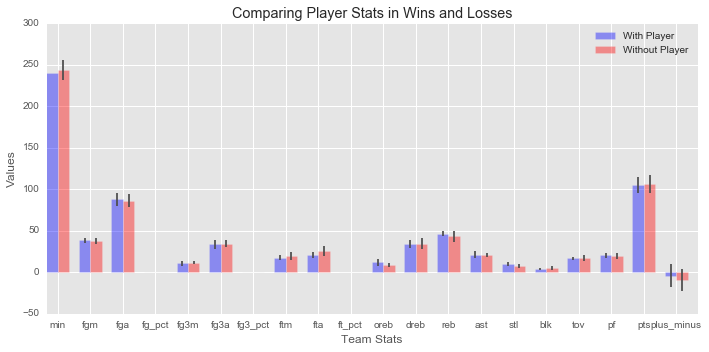

In [56]:
def get_player_missedGames(player_id,team, yr, game_log, season):
    """ Given a player id (int or string) and a season (string, ex: 2016-17), returns a (header, log_list) where the
        header represents a key describing the format of a log in log list
    Input:
        player_id (int or string): player ID number
        team (int): team_id number
        yr (str): season string, ex: 2016-17
        game_log (pd.DataFrame): Game_log
        season (str): season_id 
    Output:
        (DataFrame): a DataFrame of all games missed by a particular player in a particular season
    """
    games_missed = pd.DataFrame(columns=('game_id',"team"))
    
    (header, plog_list) = get_player_gamelogs(player_id, yr) 
    player_df = convert_to_df(header, plog_list)
    df = game_log.loc[game_log['season_id'] == season]
    df = df.loc[df['team_id'] == team]
    other_df = df.copy()
    #now have dataframe of all games for a particular team in a particular season
    i = 0
    game_list = []
    for index, row in df.iterrows():
        game = row['game_id']
        if game in list(player_df.ix[:,2].astype(int)): # he did play in this game
            df = df[df.game_id != game]
            game_list.append(game)
    
    # return games that the player did not play in
    other_df = other_df[other_df['game_id'].isin(game_list)]
            
    return df, other_df

# example jeremy lin
player_id = 202391
season = "2016-17"
team_id = 1610612751

(missed_player_df, with_player_df) = get_player_missedGames(player_id,team_id,"2016-17",league_df,"22016")
#(header, plog_list) = get_player_gamelogs(player_id, season) 

#player_df = convert_to_df(header, plog_list)

# get numerical columns
num_list = ['min','fgm','fga','fg_pct','fg3m','fg3a','fg3_pct','ftm','fta','ft_pct','oreb','dreb','reb',
              'ast','stl','blk','tov','pf','pts','plus_minus']

# get numerical columns
w_num = with_player_df.loc[:,num_list]
l_num = missed_player_df.loc[:,num_list]

w_mean_list = []
w_std_list = []
l_mean_list = []
l_std_list = []

for i in num_list:
    w_float_list = w_num[i].values.astype(float)
    l_float_list = l_num[i].values.astype(float)
    w_mean_list.append(w_float_list.mean())
    l_mean_list.append(l_float_list.mean())
    w_std_list.append(w_float_list.std())
    l_std_list.append(l_float_list.std())

n_groups = 20

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = .35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, w_mean_list, bar_width,
                 alpha=opacity,
                 color='b',
                 yerr=w_std_list,
                 error_kw=error_config,
                 label='With Player')

rects2 = plt.bar(index + bar_width, l_mean_list, bar_width,
                 alpha=opacity,
                 color='r',
                 yerr=l_std_list,
                 error_kw=error_config,
                 label='Without Player')


plt.xlabel('Team Stats')
plt.ylabel('Values')
plt.title('Comparing Player Stats in Wins and Losses')
#plt.xticks(index + bar_width, ('A', 'B', 'C', 'D', 'E'))
plt.xticks(index + bar_width, num_list)
plt.legend()

plt.tight_layout()
plt.show()

# now, compare the two

## Additional Exploratory Graphs

### Finding the cutoff value
At the beginning of every season, there is volatility in terms of the change in win-loss percentage. 

['21946' '21947' '21948' '21949' '21950' '21951' '21952' '21953' '21954'
 '21955' '21956' '21957' '21958' '21959' '21960' '21961' '21962' '21963'
 '21964' '21965' '21966' '21967' '21968' '21969' '21970' '21971' '21972'
 '21973' '21974' '21975' '21976' '21977' '21978' '21979' '21980' '21981'
 '21982' '21983' '21984' '21985' '21986' '21987' '21988' '21989' '21990'
 '21991' '21992' '21993' '21994' '21995' '21996' '21997' '21998' '21999'
 '22000' '22001' '22002' '22003' '22004' '22005' '22006' '22007' '22008'
 '22009' '22010' '22011' '22012' '22013' '22014' '22015' '22016']
    season_id     team_id team_abbreviation            team_name   game_id  \
569     21946  1610610025               CHS        Chicago Stags  24600048   
316     21946  1610610035               HUS      Toronto Huskies  24600051   
363     21946  1610610028               DEF      Detroit Falcons  24600053   
453     21946  1610610031               PIT   Pittsburgh Ironmen  24600055   
177     21946  1610610036        

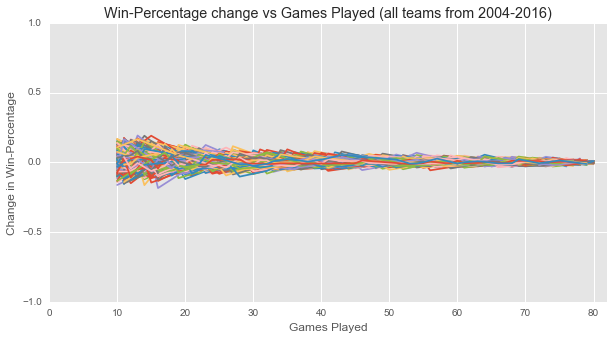

In [57]:
## Graph Win-loss against number of games

all_years_id = home_games_with_cutoff["season_id"].unique()
print all_years_id
print home_games_with_cutoff.head()
print list(home_games_with_cutoff.columns.values)
for year in all_years_id:
    curr_year = home_games_with_cutoff[(home_games_with_cutoff["season_id"] ==year)]
    all_teams = curr_year["team_abbreviation"].unique()
    for team in all_teams:
        newdf = curr_year[(curr_year["team_abbreviation"] ==team)]
        temp = newdf['home_win_pct'] - newdf['home_win_pct'].shift(-1) # difference in win_pct
        plt.plot(newdf["home_game_count"],temp)
plt.axis([0,82,-1,1])
plt.xlabel('Games Played')
plt.ylabel('Change in Win-Percentage')
plt.title('Win-Percentage change vs Games Played (all teams from 2004-2016)')

# Bivariate Analysis
For each of our proposed preditors that we mentioned earlier, we created bivariate scatterplots of these variables for the home and away teams. For these graphs, we inspect the previous season (2015-16). Each of the points are color coded: games that were won by the home team are blue while lost games are red. Hovering over each point shows the home team, the matchup of teams, and an whether or not the away team was playing a back to back game (1 for back to back, 0 for not).

In [72]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.charts import Bar
from bokeh.charts import Scatter
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook

# Plot of Home W/L Percentage vs. Away W/L Percentage
all_years_id = home_games_with_cutoff["season_id"].unique()
# Look at the previous completed season
testYear =  home_games_with_cutoff[(home_games_with_cutoff["season_id"] =="22015")]

# Based on home team, color losses as red and wins as blue 
colormap = {'L': 'red', 'W': 'blue', }
colors = [colormap[x] for x in testYear["wl"]]

# Import the nba dataframe of the given year as ColumnDataSource 
source = ColumnDataSource(data=testYear)

# Variables we want to show in the hover: university name and ranking
hover = HoverTool(tooltips=[("Home", "@team_abbreviation"), ("Game", "@matchup"), ("Away BB", "@away_back_to_back")])

# Add in labels to the graph
yearNum = "2015"
title = "Home Vs. Away - Win/Loss % Year " + yearNum
p = figure(title = title, tools = [hover, "resize", "box_zoom", "reset"])
p.xaxis.axis_label = 'Away Team W/L %'
p.yaxis.axis_label = 'Home Team W/L %'

# Plot the points for the graph
p.circle(testYear["away_win_pct"], testYear["home_win_pct"], color=colors, fill_alpha=0.2, size=10, source = source)
# Add a line of slope one to visually divide points
p.line([0, 1], [0, 1], line_width=2, color = "black")

# Display inline
output_notebook()
show(p)

SyntaxError: invalid syntax (<ipython-input-72-5e64c27b9159>, line 41)

<img src="WinLoss.png", width = 500, height = 500>

In [67]:
# Plot of Home Avg Pt Diff vs. Away Avg Pt Diff
all_years_id = home_games_with_cutoff["season_id"].unique()

# Look at the previous completed season
testYear =  home_games_with_cutoff[(home_games_with_cutoff["season_id"] =="22015")]

# Based on home team, color losses as red and wins as blue 
colormap = {'L': 'red', 'W': 'blue', }
colors = [colormap[x] for x in testYear["wl"]]

# Import the nba dataframe of the given year as ColumnDataSource
source = ColumnDataSource(data=testYear)

# Variables we want to show in the hover: university name and ranking
hover = HoverTool(tooltips=[("Home", "@team_abbreviation"), ("Game", "@matchup"), ("Away BB", "@away_back_to_back")])

# Add in labels to the graph
yearNum = "2015"
title = "Home Vs. Away - Avg Pt Diff Year " + yearNum
p = figure(title = title, tools = [hover, "resize", "box_zoom", "reset"])
p.xaxis.axis_label = 'Away Team Avg Pt Diff'
p.yaxis.axis_label = 'Home Teams Avg Pt Diff'

# Plot the points for the graph
p.circle(testYear["away_avg_pt_diff"], testYear["home_avg_pt_diff"], color=colors, fill_alpha=0.2, size=10, source = source)
# Add a line of slope one to visually divide points
p.line([-15, 15], [-15, 15], line_width=2, color = "black")

# Display inline
output_notebook()
show(p)

Loading BokehJS ...

<img src="AvgPtDiff.png", width = 500, height = 500>

In [68]:
# Plot of Home W/L Percentage Previous N Games vs. Away W/L Percentage Previous N games
all_years_id = home_games_with_cutoff["season_id"].unique()
# Hard code the year we are looking at for now
testYear =  home_games_with_cutoff[(home_games_with_cutoff["season_id"] =="22015")]

# Based on home team, color losses as red and wins as blue 
colormap = {'L': 'red', 'W': 'blue', }
colors = [colormap[x] for x in testYear["wl"]]

# Import the nba dataframe of the given year as ColumnDataSource
source = ColumnDataSource(data=testYear)

# Variables we want to show in the hover: university name and ranking
hover = HoverTool(tooltips=[("Home", "@team_abbreviation"), ("Game", "@matchup"), ("Away BB", "@away_back_to_back")])

# Add in labels to the graph
yearNum = "2015"
title = "Home Vs. Away - Win/Loss % Last 8 Games " + yearNum
p = figure(title = title, tools = [hover, "resize", "box_zoom", "reset"])
p.xaxis.axis_label = 'Away Team Win/Loss % Last 8 Games'
p.yaxis.axis_label = 'Home Team Win/Loss % Last 8 Games'

# Plot the points for the graph
p.circle(testYear["away_win_pct_N"], testYear["home_win_pct_N"], color=colors, fill_alpha=0.2, size=10, source = source)
p.line([0, 1], [0, 1], line_width=2, color = "black")

# Display inline
output_notebook()
show(p)

Loading BokehJS ...

In [70]:
# Plot of Home Team W/L Percentage as Home vs. Away W/L Percentage as Away 
all_years_id = home_games_with_cutoff["season_id"].unique()
# Hard code the year we are looking at for now
testYear =  home_games_with_cutoff[(home_games_with_cutoff["season_id"] =="22015")]

# Based on home team, color losses as red and wins as blue 
colormap = {'L': 'red', 'W': 'blue', }
colors = [colormap[x] for x in testYear["wl"]]

# Import the nba dataframe of the given year as ColumnDataSource
source = ColumnDataSource(data=testYear)

# Variables we want to show in the hover: university name and ranking
hover = HoverTool(tooltips=[("Home", "@team_abbreviation"), ("Game", "@matchup"), ("Away BB", "@away_back_to_back")])

# Add in labels to the graph
yearNum = "2015"
title = "Home Win % as Home vs Away Win % as Away " + yearNum
p = figure(title = title, tools = [hover, "resize", "box_zoom", "reset"])
p.xaxis.axis_label = 'Away Team Win/Loss as Away Team'
p.yaxis.axis_label = 'Home Team Win/Loss as Home Team'

# Plot the points for the graph
p.circle(testYear["away_win_pct_as_away"], testYear["home_win_pct_as_home"], color=colors, fill_alpha=0.2, size=10, source = source)
p.line([0, 1], [0, 1], line_width=2, color = "black")

# Display inline
output_notebook()
show(p)

Loading BokehJS ...

# Hypothesis Testing: Is back to back significant?
We want to examine whether or not playing back to back games has a significant effect of lowering the chances that any given team will lose the next game. For each team, we look at their win loss percentages of back to back games compared to non back to back games across several seasons, and run a hypothesis test to see if the true mean difference in win loss percentage for regular games and back to back games is non-zero. We run this hypothesis test at an alpha level of 0.05. We look to see whether this was a significant effect for many teams in the league or just a few of them. 

Null Hypothesis: 
The true difference in win loss records between regular games and back to back games is zero.

Alternative: 
The win loss record of regular games is higher than that of the win loss record of back to back games

In [62]:
import scipy.stats as st
from scipy.stats import t
from scipy.stats import norm

def teamPercentages(teamID, game_log):
    """ Given a team id (int or string) returns a (list, list) representing win loss percentages for back to back 
        and regular games
    Input:
        teamID (int): team_id number
        game_log (pd.DataFrame): Game_log - Needs all games (not just home games) listed
    Output:
        (list, list): a tuple of lists where each list contains the number of wins and number of games played for a 
                      given category, where the first list represents back to back games and the second list 
                      represents regular games.
    """
    seasons = game_log["season_id"].unique()
    # Initialize lists which store the percentages for back to back games and regular games for each season
    bbList = []
    regList = []
    # Initialize counters for games 
    bbWins = 0 
    bbGames = 0
    regWins = 0
    regGames = 0
    # Iterate through all seasons of the dataframe 
    for season in seasons:
        # Get dataframe that only contains games from this season of the team of interest
        currDf = game_log[(game_log["season_id"] == season) & ((game_log["team_id"] == teamID) | (game_log["opp_team_id"] == teamID))]
        # Iterate over the dataframe
        for (index, row) in currDf.iterrows():
            # Determine whether this is a home or away game
            if (row["team_id"] == teamID):
                home = True
            else:
                home = False
            # Case 1: Home back to back game 
            if (home and row["home_back_to_back"] == 1):
                bbGames += 1
                if (row["wl_binary"] == 1):
                    bbWins += 1
            # Case 2: Away back to back game
            if(home == False and row["away_back_to_back"] == 1):
                bbGames += 1
                if (row["wl_binary"] == 0):
                    bbWins += 1
            # Otherwise we have regular games
            else:
                regGames += 1
                if (home and row["wl_binary"] == 1):
                    regWins += 1
                elif (home == False and row["wl_binary"] == 0):
                    regWins += 1
    # Add the num of won and total games in the respective lists 
    bbList.append(bbWins)
    bbList.append(bbGames)
    regList.append(regWins)
    regList.append(regGames)
    return (bbList, regList)

#print teamPercentages(1610612742, home_games)

def leaguePercentages(game_log, season_id):
    """ For all teams in the league, generate their win loss percentages for back to back and regular games 
        across all seasons beyond a specific season and add the result in a dictionary. 
    Input: 
        game_log (pd.Dataframe): Dataframe containing all the game logs (all games, not just home)
        season_id (string): season id in which we only look at the results occuring at or after this season 
    Output:
        returnDict: (string, (List, List)) where key represents the team name and value is the tuple of 
                                           lists. Each list contains the number of wins and total games played, 
                                           where the first list represents back to back games and the second list 
                                           represents regular games
    """
    # Index out the seasons 
    newLog = game_log[game_log["season_id"] >= season_id]
    # Initialize the dictionary for all teams
    returnDict = {}
    teamList = newLog["team_id"].unique()
    # Iterate over all teams and call above helper function to generate the lists of win loss % for each team
    for teamID in teamList:
        returnDict[team] = teamPercentages(teamID, newLog)
    return returnDict

def hypothesisTest(bbList, regList):
    """ Run a hypothesis test to see whether the true mean win loss percentage of regular games is higher than
        the true mean win loss percentage of back to back games for a specific team over many seasons.
    Input: 
        bbList (List): List containing the win loss percentages of a team for back to back games over many seasons
        regList (List): List containing the win loss percentages of a team for regular games over many seasons 
    Output:
        result: (Boolean) where 1 represents regular game win loss percentage being significantly greater than the 
                          win loss percentage for back to back games given the inputted data.
    """
    # Get number of back to back and reg games 
    bbWins = bbList[0]
    nBB = bbList[1]
    regWins = regList[0]
    nReg = regList[1]
    # Get our win loss percentages for back to back and regular games 
    bbProp = bbWins / float(nBB)
    regProp = regWins / float(nReg)
    # Caluclate the pooled proportion and pooled standard deviation 
    pooledProp = (bbWins + regWins) / float(nBB + nReg)
    pooledSE = np.sqrt(pooledProp * (1 - pooledProp) * ((1/float(nBB)) + (1/float(nReg))))
    propDiff = regProp - bbProp
    z = propDiff / float(pooledSE)
    # Find the cutoff for alpha = 0.05 
    cutoff = norm.ppf(0.95, loc = 0, scale = 1)
    return z > cutoff 
    
def testLeague(game_log, season_id):
    """ For all teams in the league, run the hypothesis tests comparing win loss percentages between back to back games
        and non back to back games. 
    Input: 
        game_log (pd.Dataframe): Dataframe containing all the game logs (all games, not just home)
        season_id (string): season id in which we only look at the results occuring at or after this season  
    Output:
        result: (Float, Dictionary) Tuple containing an int and a dictionary. The float represents the percentage of teams
                                    in which back to back games is significant from the hypothesis test. The dictionary 
                                    has keys being the team_id, and values as booleans of whether or not there was a 
                                    significant difference between the records
    """
    # Index out the seasons 
    newLog = game_log[game_log["season_id"] >= season_id]
    # Initialize the dictionary for all teams
    returnDict = {}
    teamList = newLog["team_id"].unique()
    for team in teamList:
        returnDict[team] = hypothesisTest(teamPercentages(team, newLog[newLog["season_id"] >= season_id])[0], teamPercentages(team, all_games[all_games["season_id"] >= season_id])[1])
    # Find the proportion of teams in which this difference was significant across the league 
    sig = 0 
    total = 0 
    for team in returnDict:
        if returnDict[team] == 1:
            sig += 1
        total += 1
    percSig = (sig) / float(total)
    print percSig
    return (percSig, returnDict)

#testLeague(home_games, "22004")
testLeague(home_games, "22005")
#testLeague(home_games, "22006")
#testLeague(home_games, "22007")
#testLeague(home_games, "22008")
#testLeague(home_games, "22009")

0.533333333333


(0.5333333333333333,
 {1610612737: False,
  1610612738: False,
  1610612739: True,
  1610612740: True,
  1610612741: False,
  1610612742: False,
  1610612743: True,
  1610612744: False,
  1610612745: True,
  1610612746: False,
  1610612747: True,
  1610612748: False,
  1610612749: False,
  1610612750: True,
  1610612751: True,
  1610612752: False,
  1610612753: False,
  1610612754: True,
  1610612755: True,
  1610612756: True,
  1610612757: False,
  1610612758: True,
  1610612759: True,
  1610612760: True,
  1610612761: False,
  1610612762: True,
  1610612763: True,
  1610612764: True,
  1610612765: False,
  1610612766: False})

# Visualizing the Results
Below, we run hypothesis tests on cutoff seasons starting from 2004, all the way up to 2015. We graphically display this result. This graph seems to show that as there are more and more seasons, it appears that playing back to back games is less significant compared to playing regular games. 

In [63]:
# Use the following imports 
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.charts import Bar

# Initialize the results of running the hypothesis test above on many seasons
resultsList = []
seasons = ["22004", "22005", "22006", "22007", "22008", "22009", "22010", "22011", "22012", "22013", "22014", "22015"]
# More readable list for the plot values 
readSeasons = ["2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015"]
# Compute the proportion of teams in which playing back to back was significant for 
# on passing in seasons from 2004 to 2015
for season in seasons:
    resultsList.append(testLeague(home_games, season)[0])
    
# Create a new plot with a title and axis labels
p = figure(title="Hypothesis Testing Over Cutoffs From 2004-2015", x_axis_label='Season Cutoff', y_axis_label='% of Teams Back to Back Significant')

# Add the line to the plot, specifying features of the graph 
p.line(readSeasons, resultsList, legend="% of Teams In Which Back to Back Significant", line_width=2)

# Display inline
output_notebook()
show(p)

0.533333333333
0.533333333333
0.433333333333
0.366666666667
0.3
0.266666666667
0.333333333333
0.333333333333
0.3
0.2
0.166666666667
0.166666666667


Loading BokehJS ...

# Result
The above code ran the hypothesis test comparing win loss percentages between regular and back to back games across all teams in the league from the 2005 - 2016 season so far. As the results show, for an alpha level of 0.05, we see that there is statistically significant evidence to reject the null in favor of the alternative that teams have a worse record on back to back games compared to regular games, for 53% of teams since the 2005 season.

# Adding Geographical Features
For each game, we wish to record the travel distance the team took to get there from the prior game location. To do this, we will use the `geopy` library to get latitudes and longitudes and distance calculations. Note that certain teams have changed locations, so we have to be careful. The following teams have have changed location since 2005:
1. New Orleans Hornets -> Oklahoma City (05-06, 06-07)
2. Seattle Supersonics -> Oklahoma City Thunder (08-09 to Present)

In [64]:
# set base year
temp_df_1 = all_games[all_games['season_id'] >= '22005']
team_names = temp_df_1['team_name'].unique().tolist()
print len(team_names), team_names

team_id_list = temp_df_1['team_id'].unique().tolist()
print len(team_id_list), team_id_list

temp_df = temp_df_1[temp_df_1['team_name'] == 'New Orleans/Oklahoma City Hornets']
no_okc_seasons = temp_df['season_id'].unique().tolist()
print "NO_OKC", no_okc_seasons

temp_df = temp_df_1[temp_df_1['team_name'] == 'Charlotte Bobcats']
bobcats = temp_df['season_id'].unique().tolist()
print "BOB", bobcats

temp_df = temp_df_1[temp_df_1['team_name'] == 'New Jersey Nets']
nj = temp_df['season_id'].unique().tolist()
print "NJ", nj

temp_df = temp_df_1[temp_df_1['team_name'] == 'Seattle SuperSonics']
seattle = temp_df['season_id'].unique().tolist()
print "SUPER", seattle

temp_df = temp_df_1[temp_df_1['team_name'] == 'New Orleans Hornets']
noh = temp_df['season_id'].unique().tolist()
print "NOH", noh

temp_df = temp_df_1[temp_df_1['team_name'] == 'Oklahoma City Thunder']
thunder = temp_df['season_id'].unique().tolist()
print "THUNDER", thunder

temp_df = temp_df_1[temp_df_1['team_name'] == 'Brooklyn Nets']
bkn = temp_df['season_id'].unique().tolist()
print "BKN", bkn

# dictionary mapping of team_id to team_names?
id_team = dict()
for team_id in team_id_list:
    temp_df = temp_df_1[temp_df_1['team_id'] == team_id]
    id_team[team_id] = temp_df['team_name'].unique().tolist()
print id_team

# dictionary mapping of team_name to seasons
team_seasons = dict()
for team_name in team_names:
    temp_df = temp_df_1[temp_df_1['team_name'] == team_name]
    team_seasons[team_name] = temp_df['season_id'].unique().tolist()
print team_seasons

# sanity check
for team_id in team_id_list:
    names = id_team[team_id]
    if len(names) == 0:
        raise Fail("no names for ID")
    elif len(names) == 1:
        continue
    else:
        season_list = []
        for name in names:
            seasons = team_seasons[name]
            season_list.append(seasons)
            
        common_years = list(reduce(set.intersection, map(set, season_list)))
        print len(common_years), names, common_years
        assert(len(common_years) == 0)
            
# ['Dallas Mavericks', 'New Orleans/Oklahoma City Hornets', 'Milwaukee Bucks', 'San Antonio Spurs', 
#  'Philadelphia 76ers', 'Phoenix Suns', 'Denver Nuggets', 'Sacramento Kings', 'Atlanta Hawks', 'Miami Heat', 
#  'Toronto Raptors', 'New Jersey Nets', 'Houston Rockets', 'Boston Celtics', 'Golden State Warriors', 
#  'Utah Jazz', 'Seattle SuperSonics', 'Portland Trail Blazers', 'Indiana Pacers', 'Minnesota Timberwolves', 
#  'Washington Wizards', 'Chicago Bulls', 'New York Knicks', 'Cleveland Cavaliers', 'Charlotte Bobcats', 
#  'Detroit Pistons', 'Memphis Grizzlies', 'Orlando Magic', 'Los Angeles Clippers', 'Los Angeles Lakers', 
#  'New Orleans Hornets', 'Oklahoma City Thunder', 'Brooklyn Nets', 'New Orleans Pelicans', 'Charlotte Hornets', 
#  'LA Clippers']

name_location = {'Dallas Mavericks': 'Dallas, Texas',
                'New Orleans/Oklahoma City Hornets': 'Oklahoma City, Oklahoma',
                'Milwaukee Bucks': 'Milwaukee, Wisconsin',
                'San Antonio Spurs': 'San Antonio, Texas',
                'Philadelphia 76ers': 'Philadelphia, Pennsylvania',
                'Phoenix Suns': 'Phoenix, Arizona',
                'Denver Nuggets': 'Denver, Colorado',
                'Sacramento Kings': 'Sacramento, California',
                'Atlanta Hawks': 'Atlanta, Georgia',
                'Miami Heat' : 'Miami, Florida', 
                'Toronto Raptors': 'Toronto, Ontario', 
                'New Jersey Nets': 'Newark, New Jersey', 
                'Houston Rockets': 'Houston, Texas', 
                'Boston Celtics': 'Boston, Massachusetts', 
                'Golden State Warriors' : 'Oakland, California', 
                'Utah Jazz': 'Salt Lake City, Utah', 
                'Seattle SuperSonics' : 'Seattle, Washington', 
                'Portland Trail Blazers': 'Portland, Oregon', 
                'Indiana Pacers' : 'Indianapolis, Indiana', 
                'Minnesota Timberwolves' : 'Minneapolis, Minnesota', 
                'Washington Wizards': 'Washington D.C., Virginia',
                'Chicago Bulls' : 'Chicago, Illinois', 
                'New York Knicks': 'New York City, New York', 
                'Cleveland Cavaliers' : 'Cleveland, Ohio', 
                'Charlotte Bobcats' : 'Charlotte, North Carolina',
                'Detroit Pistons' : 'Detroit, Michigan', 
                'Memphis Grizzlies' : 'Memphis, Tennessee', 
                'Orlando Magic' : 'Orlando, Florida', 
                'Los Angeles Clippers' : 'Los Angeles, California', 
                'Los Angeles Lakers' : 'Los Angleles, California', 
                'New Orleans Hornets' : 'New Orleans, Louisiana', 
                'Oklahoma City Thunder': 'Oklahoma City, Oklahoma', 
                'Brooklyn Nets': 'Brooklyn, New York', 
                'New Orleans Pelicans' : 'New Orleans, Louisiana', 
                'Charlotte Hornets' : 'Charlotte, North Carolina', 
                'LA Clippers' : 'Los Angeles, California'}

def get_team_location(team_id, season_id):
    """ Given a team id and the season_id, returns a string containing the location of the team stadium
    Input: 
        team_id (int): team id
        season_id (str): season id 
    Output:
        (str) 
    """
    names = id_team[team_id]
    
    team_name = None
    
    for name in names:
        seasons = team_seasons[name]
        if season_id in seasons:
            team_name = name
            
    assert(team_name != None)
    
    return name_location[team_name]

location = get_team_location(1610612742, '22015')
location1 = get_team_location(1610612749, '22015')

print location, location1

geolocator = Nominatim()
geo_loc = geolocator.geocode(location)

(lat1, long1) = (geo_loc.latitude, geo_loc.longitude)

geo_loc1 = geolocator.geocode(location1)

(lat2, long2) = (geo_loc1.latitude, geo_loc1.longitude)

print vincenty((lat1,long1), (lat2,long2)).miles
    
#print Geocoder.geocode(location).valid_address


36 ['Dallas Mavericks', 'Denver Nuggets', 'Phoenix Suns', 'Sacramento Kings', 'San Antonio Spurs', 'New Orleans/Oklahoma City Hornets', 'Milwaukee Bucks', 'Philadelphia 76ers', 'New York Knicks', 'Indiana Pacers', 'Utah Jazz', 'Minnesota Timberwolves', 'Miami Heat', 'Detroit Pistons', 'Atlanta Hawks', 'Cleveland Cavaliers', 'Chicago Bulls', 'Golden State Warriors', 'Houston Rockets', 'Charlotte Bobcats', 'Orlando Magic', 'Memphis Grizzlies', 'Boston Celtics', 'Portland Trail Blazers', 'Seattle SuperSonics', 'Washington Wizards', 'Los Angeles Lakers', 'Los Angeles Clippers', 'Toronto Raptors', 'New Jersey Nets', 'New Orleans Hornets', 'Oklahoma City Thunder', 'Brooklyn Nets', 'New Orleans Pelicans', 'Charlotte Hornets', 'LA Clippers']
30 [1610612742, 1610612743, 1610612756, 1610612758, 1610612759, 1610612740, 1610612749, 1610612755, 1610612752, 1610612754, 1610612762, 1610612750, 1610612748, 1610612765, 1610612737, 1610612739, 1610612741, 1610612744, 1610612745, 1610612766, 1610612753, 

# How has the NBA changed over the years?
We want to examine the change of key statistics over time in the past 40 years of the NBA. 
1. How has the standard deviation of team wins in a given season changed over different seasons?
2. How has the average point differential for a given season changed over different seasons?
3. How has the difference between the mean point differential between top teams and bottom teams changed over different seasons?

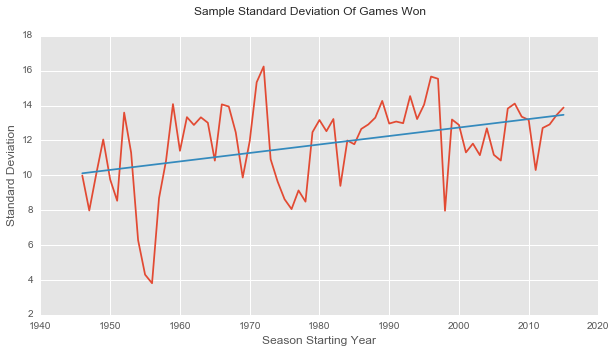

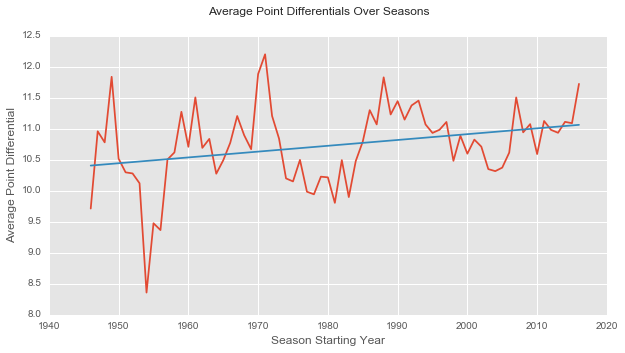

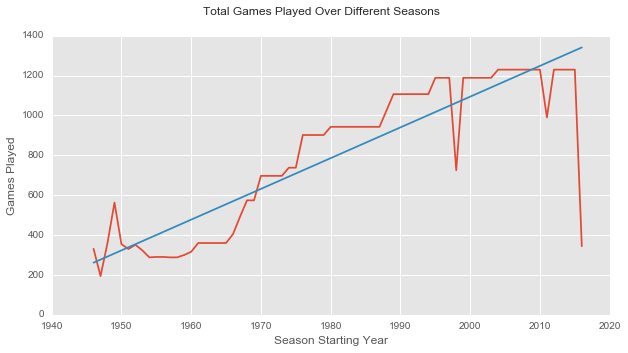

In [65]:
def get_team_wins_count(league_df, team_id, season_id):
    """ Given a df containing ALL game logs (including home and away), 
        team_id and season_id, returns number of wins the team got that season
    Input:
        league_df (pandas.DataFrame): dataframe containing post-processed league logs (both HOME and AWAY)
        team_id (int or string): player ID number
        season_id (int or string): season ID number
    Output:
        (int): number of games team won in season
    """
    
    team_id = int(team_id)
    season_id = str(season_id)
    
    #print league_df['season_id'].dtype
    #print league_df['team_id'].dtype
    
    temp_df = league_df[(league_df['season_id'] == season_id) & (league_df['team_id'] == team_id)]
    
    temp_df = temp_df.sort_values('game_date')
    
    # get last game
    last_game = temp_df.iloc[len(temp_df) - 1]
    
    #print last_game
    #assert(last_game['home_game_count'] == 81 or last_game['away_game_count'] == 81)
    
    wins = 0
    games_won_so_far = 0
    if last_game['is_home']:
        games_won_so_far = int(round(last_game['home_win_pct']*last_game['home_game_count']))
    else:
        games_won_so_far = int(round(last_game['away_win_pct']*last_game['away_game_count']))
    wins = games_won_so_far + last_game['wl_binary']
    
    return wins
    
get_team_wins_count(all_games, "1610612742", "22004")

def graph_stdev_wins(league_df):
    """ Given a df containing ALL SORTED game logs (including home and away), 
        graphs stdev of team wins over time
    Input:
        league_df (pandas.DataFrame): dataframe containing post-processed league logs (both HOME and AWAY)
    Output:
        None
    """
    season_list = league_df['season_id'].unique().tolist()
    seasons = []
    stdevs = []
    for season in season_list:
        season_df = league_df[league_df['season_id'] == season]
        
        team_list = season_df['team_id'].unique().tolist()
        
        win_counts = []
        
        for team in team_list:
            team_wins = get_team_wins_count(league_df, team, season)
            win_counts.append(team_wins)
            
        stdev = np.array(win_counts).std(ddof = 1)
        #stdevs.append(season[1:], stdev)
        seasons.append(int(season[1:]))
        stdevs.append(stdev)
        
    # remove last, unfinished year
    seasons = seasons[:len(seasons)- 1]
    stdevs = stdevs[:len(stdevs) - 1]
    fig = plt.figure()
    fig.suptitle('Sample Standard Deviation Of Games Won',fontsize=12)
    plt.xlabel('Season Starting Year')
    plt.ylabel('Standard Deviation')
    plt.plot(seasons, stdevs, seasons, 
                  np.poly1d(np.polyfit(seasons, stdevs, 1))(np.unique(seasons)))
         
graph_stdev_wins(all_games)

def graph_avg_ptdiff(league_df):
    """ Given a df containing ALL SORTED game logs (including home and away), 
        graphs average (absolute value) ptdiff over seasons
    Input:
        league_df (pandas.DataFrame): dataframe containing post-processed league logs (both HOME and AWAY)
    Output:
        None
    """
    season_list = league_df['season_id'].unique().tolist()
    seasons = []
    avg_pt_diffs = []
    for season in season_list:
        season_df = league_df[league_df['season_id'] == season]
        pt_diff = season_df['plus_minus'].values
        pt_diff = np.apply_along_axis(lambda x: np.abs(x), 0, pt_diff)
        seasons.append(int(season[1:]))
        avg_pt_diffs.append(np.mean(pt_diff))
    fig = plt.figure()
    fig.suptitle('Average Point Differentials Over Seasons',fontsize=12)
    plt.xlabel('Season Starting Year')
    plt.ylabel('Average Point Differential')
    plt.plot(seasons, avg_pt_diffs, seasons, 
                  np.poly1d(np.polyfit(seasons, avg_pt_diffs, 1))(np.unique(seasons)))

graph_avg_ptdiff(all_games)
    
def mean_ptdiff_top_bottom():
    pass

def total_games_graph(league_df):
    """ Given a df containing ALL HOME game logs, 
        graphs total games played throughout seasons
    Input:
        league_df (pandas.DataFrame): dataframe containing post-processed league logs (only HOME)
    Output:
        None
    """
    season_list = league_df['season_id'].unique().tolist()
    seasons = []
    total_games = []
    for season in season_list:
        season_df = league_df[league_df['season_id'] == season]
        #pt_diff = season_df['plus_minus'].values
        #pt_diff = np.apply_along_axis(lambda x: np.abs(x), 0, pt_diff)
        seasons.append(int(season[1:]))
        total_games.append(len(season_df))
    fig = plt.figure()
    fig.suptitle('Total Games Played Over Different Seasons',fontsize=12)
    plt.xlabel('Season Starting Year')
    plt.ylabel('Games Played')
    plt.plot(seasons, total_games, seasons, 
                  np.poly1d(np.polyfit(seasons, total_games, 1))(np.unique(seasons)))
    
total_games_graph(home_games)


    

# Naive Approach Performance
The naive approach is to choose the team with the better record so far. If the records are the same, we will classify the home team as the winner.

In [ ]:
def naive_approach_accuracy(home_games_df, season_id_list):
    """ Given a df containing ALL HOME game logs, 
        season_id, returns accuracy of naive classification
    Input:
        league_df (pandas.DataFrame): dataframe containing post-processed league logs (both HOME and AWAY)
        season_id (int or string): season ID number
    Output:
        (int): number of games team won in season
    """
    
    correct = 0
    total = 0
    
    for season_id in season_id_list:
        season_id = str(season_id)

        season_df = home_games_df[(home_games_df['season_id'] == season_id)]
        for (index, row) in season_df.iterrows():
            home_team_pct = row['home_win_pct']
            away_team_pct = row['away_win_pct']
            wl = row['wl_binary']
            classification = 0

            if (home_team_pct >= away_team_pct):
                classification = 1
            if classification == wl:
                correct += 1
            total += 1
        
    return correct/float(total)

print naive_approach_accuracy(home_games,["22010","22011","22012"])
    
def graph_naive(home_games_df):
    """ Given a df containing ALL HOME game logs, 
        graph_naive graphs the naive classification accuracy across seasons
    Input:
        home_games_df (pandas.DataFrame): dataframe containing post-processed 
            league logs (HOME)
    Output:
        None
    """
    season_list = home_games_df['season_id'].unique().tolist()
    seasons = []
    naives = []
    for season in season_list:
        season_df = league_df[league_df['season_id'] == season]
        naives.append(naive_approach_accuracy(home_games_df, [season]))
        #pt_diff = season_df['plus_minus'].values
        #pt_diff = np.apply_along_axis(lambda x: np.abs(x), 0, pt_diff)
        seasons.append(int(season[1:]))
        #avg_pt_diffs.append(np.mean(pt_diff))
    fig = plt.figure()
    fig.suptitle('Naive Classification Accuracy',fontsize=12)
    plt.xlabel('Season Starting Year')
    plt.ylabel('Accuracy')
    plt.plot(seasons, naives, seasons, 
                  np.poly1d(np.polyfit(seasons, naives, 1))(np.unique(seasons)))

graph_naive(home_games)

# Data Normalization
We wish to normalize our data for cleaner modeling, and to help SVM converge faster.

In [ ]:
# home games
# divide into training set, validation set, test set
# training_set = home_games_with_cutoff[(home_games_with_cutoff['season_id'] >= "22005") &
#                                      (home_games_with_cutoff['season_id'] <= "22009")]
# validation_set = home_games[(home_games['season_id'] >= "22010") & 
#                             (home_games['season_id'] <= "22012")]
# test_set = home_games[(home_games['season_id'] >= "22013") & 
#                       (home_games['season_id'] <= "22016")]

training_set = df_with_elev_mileage_with_cutoff[(home_games_with_cutoff['season_id'] >= "22005") &
                                     (home_games_with_cutoff['season_id'] <= "22009")]
validation_set = df_with_elev_mileage[(home_games['season_id'] >= "22010") & 
                            (home_games['season_id'] <= "22012")]
test_set = df_with_elev_mileage[(home_games['season_id'] >= "22013") & 
                      (home_games['season_id'] <= "22016")]

def normalize(df, param_labels, soft=True):
    """ Given a df containing game logs to be normalized, returns a new normalized dataframe
    Input:
        df (pandas.DataFrame): dataframe containing post-processed league logs
        list (str): list of column labels to normalize
        soft (bool): whether to do soft normalization or hard normalization
    Output:
        pd.DataFrame
    """
    # soft normalization
    if (soft):
        for label in param_labels:
            mean = np.mean(df[label])
            std = (df[label]).std()
            
            new_row = df[label].apply(lambda x: (x-mean)/(2*std))
    
            df.loc[:,label] = new_row 
    # hard normalization
    else:
        pass
    return df

# RUN THIS IF YOU WANT NORMALIZED STUFF
training_set = normalize(training_set, ['home_avg_pt_diff','away_avg_pt_diff', 'elevation','home_mileage','away_mileage'])
validation_set = normalize(validation_set, ['home_avg_pt_diff','away_avg_pt_diff','elevation','home_mileage','away_mileage'])
test_set = normalize(validation_set, ['home_avg_pt_diff','away_avg_pt_diff','elevation','home_mileage','away_mileage'])

#training_set = normalize(training_set, ['home_avg_pt_diff','away_avg_pt_diff', 'home_win_pct', "away_win_pct", 'home_win_pct_N', 'away_win_pct_N','away_win_pct_as_away',
            #'home_win_pct_as_home', 'home_back_to_back','away_back_to_back'])
#validation_set = normalize(validation_set, ['home_avg_pt_diff','away_avg_pt_diff', 'home_win_pct', "away_win_pct", 'home_win_pct_N', 'away_win_pct_N','away_win_pct_as_away',
            #'home_win_pct_as_home', 'home_back_to_back','away_back_to_back'])
#test_set = normalize(validation_set, ['home_avg_pt_diff','away_avg_pt_diff', 'home_win_pct', "away_win_pct", 'home_win_pct_N', 'away_win_pct_N','away_win_pct_as_away',
            #'home_win_pct_as_home', 'home_back_to_back','away_back_to_back'])


# SVM
In addition to Linear and Logistic Regression, we wish to try support vector machines for classification of win-loss

In [ ]:
def create_feature_matrix(df, features):
    """ Given a normalized df, returns a matrix of features and the binary w/l response
    Input:
        df (pandas.DataFrame): dataframe containing post-processed, normalzied league logs
        list (str): list of features to be included
    Output:
        (array-like, array-like)
    """
    return (df[features].values, df['wl_binary'].values)

# modify this as see fit
features = ['home_win_pct', 'away_win_pct',
           'home_win_pct_N', 'away_win_pct_N','away_win_pct_as_away',
            'home_win_pct_as_home', 'home_back_to_back','away_back_to_back','elevation','away_mileage']

training_matrix, training_response = create_feature_matrix(training_set, features)
validation_matrix, validation_response = create_feature_matrix(validation_set, features)


In [ ]:
# Run SVM
#clf = SVC(C=1e4, kernel='linear')
#clf = SVC(C = 2**(3), gamma = 2**(-15), kernel = 'linear')
clf = LinearSVC(C=2**(3), loss='squared_hinge', dual = False, penalty = "l1", )
clf.fit(training_matrix, training_response)


In [ ]:
valid_pred = clf.predict(validation_matrix)

In [ ]:
import sys
def get_svm_accuracy(pred, actuals):
    """ Given predictions and actuals, calculates prediction accuracy
    Input:
        pred (array-like): list of predictions
        actuals (array-like): list of actual outputs
    Output:
        float
    """
    
    assert(len(pred) == len(actuals))
    
    correct = 0
    total = 0
    
    for i in xrange(len(pred)):
        if pred[i] == actuals[i]:
            correct += 1
        total += 1
        
    return correct/float(total)

print get_svm_accuracy(valid_pred, validation_response)

# Run grid search to find the optimal gamma and C values 
def gridSearch():
    cPower = -5
    bestC = 0
    bestG = 0
    optimal = sys.minint 
    for c in xrange(11):
        cVal = 2**(cPower)
        gPower = -15 
        for g in xrange(10):
            gVal = 2**(gPower)
            clf = SVC(C = cVal,gamma = gVal, kernel='linear')
            clf.fit(training_matrix, training_response)
            valid_pred = clf.predict(validation_matrix)
            currVal = get_svm_accuracy(valid_pred, validation_response)
            print currVal, gPower, cPower
            if optimal < currVal:
                optimal = currVal 
                bestC = cVal  
                bestG = gVal
            gPower += 2
        cPower += 2
    return (bestC, bestG)

#gridSearch() # (9223372036854775807, 9223372036854775807) - (63, 63)
    

In [ ]:
# random code to count number of back to back wins
print len(home_games[(home_games['team_id'] == 1610612742) &(home_games['wl_binary'] == 1)
         & (home_games['season_id'] == "22015") & (home_games['home_back_to_back'] == 1)])

print len(home_games[(home_games['opp_team_id'] == 1610612742) &(home_games['wl_binary'] == 0)
         & (home_games['season_id'] == "22015") & (home_games['away_back_to_back'] == 1)])

print len(home_games[(home_games['team_id'] == 1610612742)
         & (home_games['season_id'] == "22015") & (home_games['home_back_to_back'] == 1)])

print len(home_games[(home_games['opp_team_id'] == 1610612742)
         & (home_games['season_id'] == "22015") & (home_games['away_back_to_back'] == 1)])

In [ ]:
def validate_SVC(C=1e4, gamma='auto'):
    pass
    